# Pre-processing the data

In [ ]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

# Loading the first CSV file
csv_file1 = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Dissertation/Group 2.csv")

# Checking for missing values and impute with the median (if any)
csv_file1.fillna(csv_file1.median(numeric_only=True), inplace=True)

# Checking for duplicate rows to remove
csv_file1.drop_duplicates(inplace=True)

# Reseting the index to #fixed the reindexing error
csv_file1.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()       # Normalize the data using Min-Max scaling
scaled_data = pd.DataFrame(scaler.fit_transform(csv_file1.iloc[:, 1:]), columns=csv_file1.columns[1:])


scaled_data.insert(0, "ID", csv_file1["ID"]) # Adding the student IDs back to the scaled data


scaled_data["Average_MS123"] = scaled_data.loc[:, "MS1":"MS3"].mean(axis=1) # Calculating the average milestone score for each student
scaled_data["Average_MS4567"] = scaled_data.loc[:, "MS4":"MS7"].mean(axis=1)
scaled_data["Average_MS8910"] = scaled_data.loc[:, "MS8":"MS10"].mean(axis=1)
scaled_data["Average_MS11"] = scaled_data["MS11"]


total_score_threshold = 0.22    #  thresholds for eligibility

# Create a new column indicating if a student is eligible for Stage 3
scaled_data["Stage_3_Eligible"] = (scaled_data["Score"] >= total_score_threshold).astype(int)

# Select the required columns
preprocessed_data = scaled_data[["ID", "Average_MS123", "Average_MS4567", "Average_MS8910", "Average_MS11", "Score", "Stage_3_Eligible"]]

preprocessed_data.to_csv("/content/drive/MyDrive/ColabNotebooks/Dissertation/preprocessed2.csv", index=False)  # Save the preprocessed data with the added features to a new CSV file



# Methodology of the Genetic Algorithm

In [ ]:
import numpy as np

def initialize_group_formation(total_group_formations, num_students, group_size):
    group_formations = []

    for _ in range(total_group_formations):
        student_order = np.random.permutation(num_students)
        group_formations.append(student_order)

    return group_formations

def circular_crossover(parent1, parent2):
    num_students = len(parent1)

    # Choosing random crossover points
    idx1, idx2 = np.random.choice(num_students, 2, replace=False)

    # Perform circular crossover
    offspring1  = np.roll(parent1, num_students - idx1)
    offspring2  = np.roll(parent2, num_students - idx2)

    return offspring1, offspring2



def rearrange_students(student_order, rearrangement_rate):
    num_students = len(student_order)

    for i in range(num_students):
        if np.random.rand() < rearrangement_rate:
            # Choosing another random position for the swap
            j = np.random.randint(num_students)

            # Swapinging the students  at positions i and j
            student_order[i], student_order[j] = student_order[j], student_order[i]

    return student_order


def tournament_selection(group_formations, fitness_values):
    # Tournament selection
    tournament_size = 4
    selected_group_formations  = []
    total_group_formations  = len(group_formations)

    for _ in range(total_group_formations):
        # Select tournament_size random indices from the population
        competitor_indices = np.random.choice(total_group_formations, tournament_size, replace=False)
        competitor_fitness_values = [fitness_values[i] for i in competitor_indices]

        # Choose the best individual from the tournament
        best_competitor_index = np.argmax(competitor_fitness_values)
        selected_group_formations.append(group_formations[competitor_indices[best_competitor_index]])

    return selected_group_formations





def fitness_function(student_order, students, group_size):
    total_diff = 0
    num_students = len(students)

    # Weights for each attribute
    weights = {
        'Score': 1,
        'Average_MS123': 1,
        'Average_MS4567': 1,
        'Average_MS8910': 1,
        'Average_MS11': 1
    }

    idx = 0
    num_groups = 0
    while idx < num_students:
        current_group_size = group_size if num_groups % 2 == 0 else group_size + 1
        group_indices = student_order[idx:idx + current_group_size]
        group = students.iloc[group_indices]

        # Calculate the difference in each attribute within the group
        diff_score = group['Score'].std() * weights['Score']
        diff_avg_ms123 = group['Average_MS123'].std() * weights['Average_MS123']
        diff_avg_ms4567 = group['Average_MS4567'].std() * weights['Average_MS4567']
        diff_avg_ms8910 = group['Average_MS8910'].std() * weights['Average_MS8910']
        diff_avg_ms11 = group['Average_MS11'].std() * weights['Average_MS11']

        # Sum the differences for the current group
        total_diff += diff_score + diff_avg_ms123 + diff_avg_ms4567 + diff_avg_ms8910 + diff_avg_ms11

        idx += current_group_size
        num_groups += 1

    # Calculate the average difference across all groups
    avg_diff = total_diff / num_groups

    # Invert the difference to get a fitness value (higher is better)
    fitness = 1 / (1 + avg_diff)

    return fitness

def get_group_formation(student_order, students, group_size):
    groups = []
    num_students = len(students)

    idx = 0
    num_groups = 0
    while idx < num_students:
        current_group_size = group_size if num_groups % 2 == 0 else group_size + 1
        group_indices = student_order[idx:idx + current_group_size]
        group = students.iloc[group_indices]
        groups.append(group)
        idx += current_group_size
        num_groups += 1

    return groups

def termination_criterion_met(current_iteration, max_iterations, best_fitness, target_fitness, verbose=False):
    # Terminate if the maximum number of iterations is reached or the target fitness is achieved
    if verbose and current_iteration  % 50 == 0:
        print(f"Iteration  {current_iteration }: Best Fitness = {best_fitness:.4f}")

    return current_iteration >= max_iterations or best_fitness >= target_fitness






# Integration on PBL

In [ ]:
import numpy as np
import pandas as pd
import random

target_fitness_score = 0.95  # target_fitness_score value based on the requirements

# Set the parameters for the CGA
population_size = 500
max_iterations = 5000
group_size = 5  # For groups of 5 to 6 people
rate = 0.01


data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Dissertation/preprocessed2.csv")
eligible_students = data[data['Stage_3_Eligible'] == 1]

# Lists to save the relevant results from each iteration
best_fitness_history = []
best_group_formations = []

# Initialize the population
population = initialize_group_formation(population_size, len(eligible_students), group_size)

# CGA main loop
for iteration in range(max_iterations):
    # Evaluation of the formation scores of the student orders
    fitness_values = [fitness_function(student_order, eligible_students, group_size) for student_order in population]

    # Selecting the student orders for reproduction
    mating_pool = tournament_selection(population, fitness_values)

    # Perform the crossover and rearrange  to create a new population
    new_population = []


    best_formation_score = max(fitness_values)   # find the best formation score in the current iteration and store it
    best_fitness_history.append(best_formation_score)


    best_individual_index = np.argmax(fitness_values)# find the best individual (group formation) in the current iteration and store it
    best_individual = population[best_individual_index]
    best_group_formation = get_group_formation(best_individual, eligible_students, group_size)
    best_group_formations.append(best_group_formation)

    for i in range(population_size // 2):
        parent1, parent2 = random.sample(mating_pool,2)
        offspring1, offspring2 = circular_crossover(parent1, parent2)
        offspring1 = rearrange_students(offspring1, rate)
        offspring2 = rearrange_students(offspring2, rate)
        new_population.append(offspring1)
        new_population.append(offspring2)

    # Replacing the old one
    population = new_population

    # Calculate the best formation score in the current population
    best_formation_score = max(fitness_values)

    if termination_criterion_met(iteration, max_iterations, best_formation_score, target_fitness_score, verbose=True):
        break

best_overall_index = np.argmax(best_fitness_history)
best_overall_group_formation = best_group_formations[best_overall_index]

best_student_order_index = np.argmax(fitness_values)# Get the best student order and its corresponding group formation
best_student_order = population[best_student_order_index]
best_group_formation = get_group_formation(best_student_order, eligible_students, group_size)

print("Best group formation:", best_group_formation)



Iteration  0: Best Fitness = 0.5189
Iteration  50: Best Fitness = 0.5892
Iteration  100: Best Fitness = 0.6110
Iteration  150: Best Fitness = 0.6172
Iteration  200: Best Fitness = 0.6143
Iteration  250: Best Fitness = 0.6241
Iteration  300: Best Fitness = 0.6241
Iteration  350: Best Fitness = 0.6241
Iteration  400: Best Fitness = 0.6241
Iteration  450: Best Fitness = 0.6241
Iteration  500: Best Fitness = 0.6231
Iteration  550: Best Fitness = 0.6231
Iteration  600: Best Fitness = 0.6231
Iteration  650: Best Fitness = 0.6231
Iteration  700: Best Fitness = 0.6231
Iteration  750: Best Fitness = 0.6231
Iteration  800: Best Fitness = 0.6218
Iteration  850: Best Fitness = 0.6218
Iteration  900: Best Fitness = 0.6256
Iteration  950: Best Fitness = 0.6237
Iteration  1000: Best Fitness = 0.6237
Iteration  1050: Best Fitness = 0.6237
Iteration  1100: Best Fitness = 0.6237
Iteration  1150: Best Fitness = 0.6237
Iteration  1200: Best Fitness = 0.6237
Iteration  1250: Best Fitness = 0.6224
Iteration

# Creating the plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_best_fitness_per_generation(best_fitness_history):
    plt.plot(best_fitness_history)
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness Value')
    plt.title('Best Fitness Value per Iteration')
    plt.show()


def plot_student_individual_attributes(groups, students, attributes):
    long_format_data = pd.DataFrame(columns=['Group', 'Student', 'Attribute', 'Value'])

    for group_idx, group in enumerate(groups):
        for _, student_row in group.iterrows():
            student_id = student_row['ID']
            for attribute in attributes:
                value = student_row[attribute]
                long_format_data = long_format_data.append(
                    {'Group': group_idx + 1, 'Student': student_id, 'Attribute': attribute, 'Value': value},
                    ignore_index=True)

    plt.figure(figsize=(15, 8))
    sns.barplot(x='Attribute', y='Value', hue='Student', data=long_format_data, ci=None)
    plt.legend(title='Student', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title('Attributes of Students in Each Group')
    plt.show()

def plot_student_average_attributes(groups, students, attributes):
    long_format_data = pd.DataFrame(columns=['Group', 'Attribute', 'Average Value'])

    for group_idx, group in enumerate(groups):
        for attribute in attributes:
            avg_value = group[attribute].mean()
            long_format_data = long_format_data.append(
                {'Group': f'Group {group_idx + 1}', 'Attribute': attribute, 'Average Value': avg_value},
                ignore_index=True)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Group', y='Average Value', hue='Attribute', data=long_format_data, ci=None)
    plt.legend(title='Attribute', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title('Average Attribute Values in Each Group')
    plt.show()

def plot_student_attribute_distribution(students, attributes):
    # Reshape the data to long format
    long_format_data = pd.melt(students, id_vars=['ID'], value_vars=attributes, var_name='Attribute', value_name='Value')

    plt.figure(figsize=(12, 8))
    sns.histplot(data=long_format_data, x='Value', hue='Attribute', multiple='stack', binwidth=0.1)
    plt.title('Distribution of Student Attributes')
    plt.show()



def plot_group_score_distribution(groups):
    group_scores = [group['Score'].mean() for group in groups]
    plt.figure(figsize=(12, 8))
    sns.histplot(group_scores, binwidth=0.1)
    plt.xlabel('Group Score')
    plt.title('Distribution of Group Scores')
    plt.show()


def plot_group_score_boxplot(groups):
    group_scores = pd.DataFrame([group['Score'].tolist() for group in groups]).T
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=group_scores)
    plt.xlabel('Group')
    plt.ylabel('Score')
    plt.title('Boxplot of Group Scores')
    plt.show()



# Visualizing the results

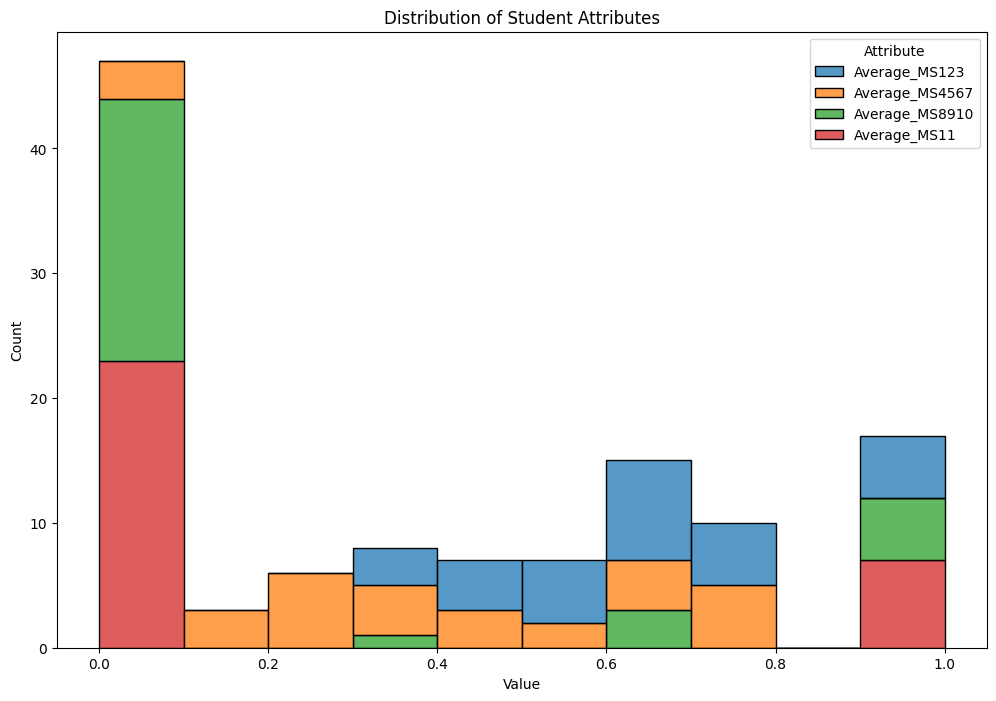

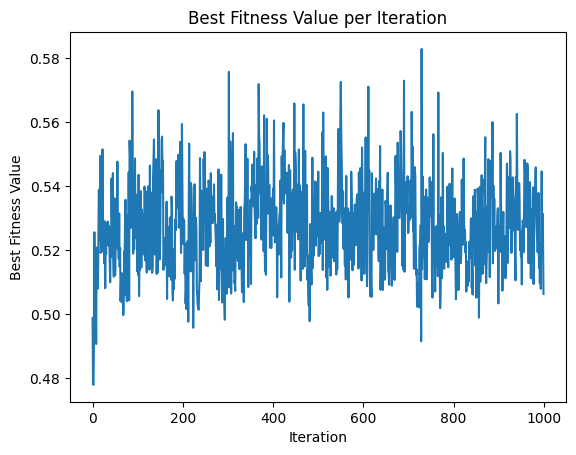

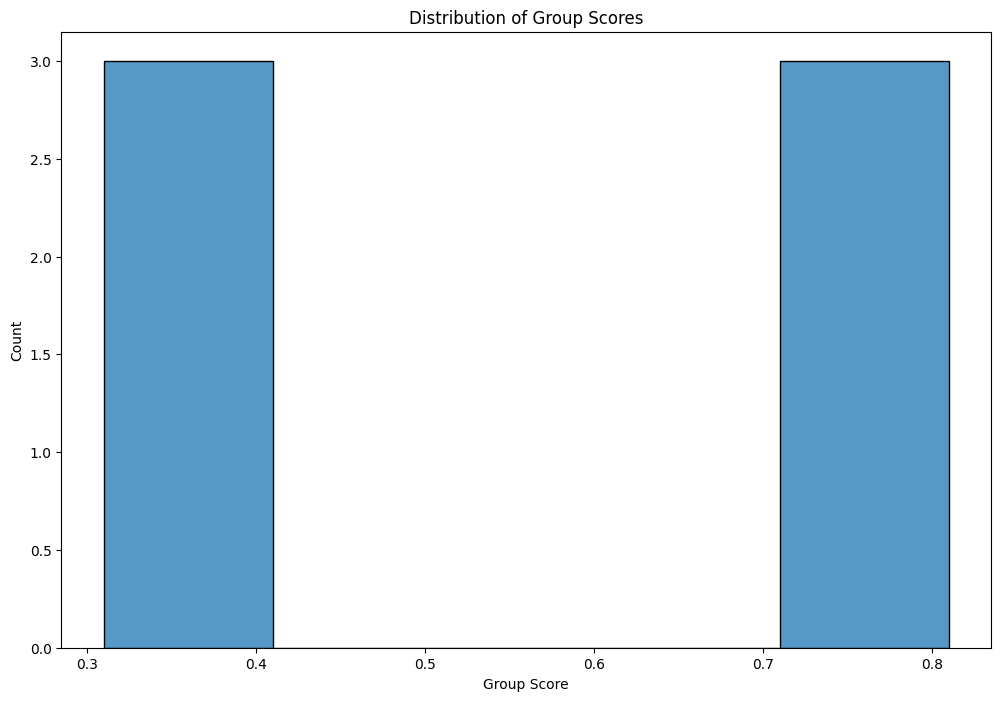

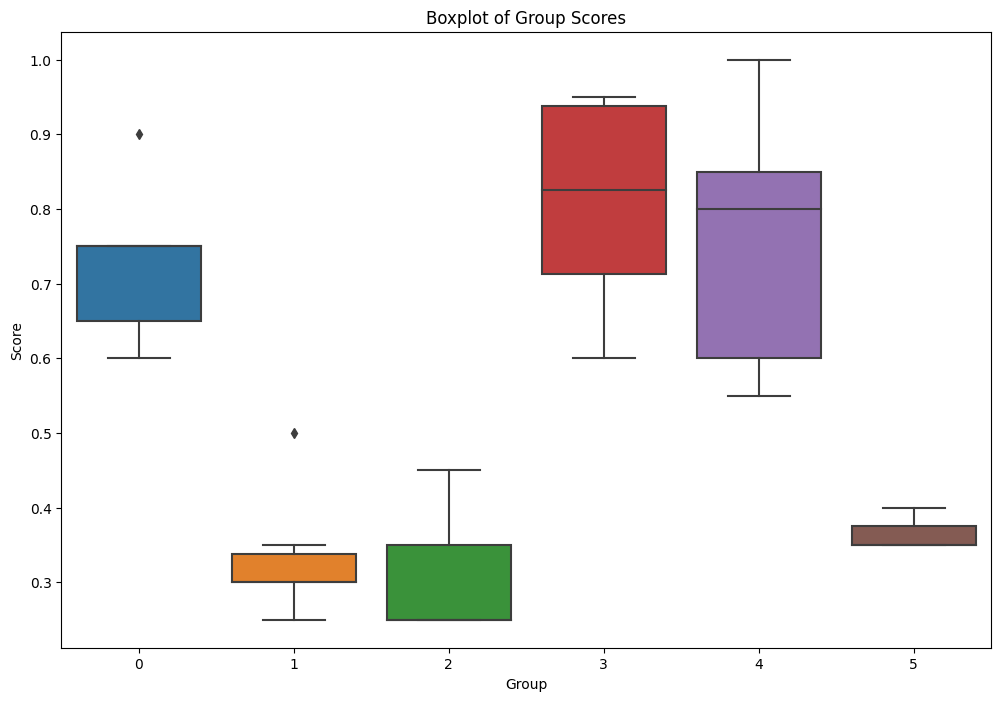

<ipython-input-28-7985a9221630>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

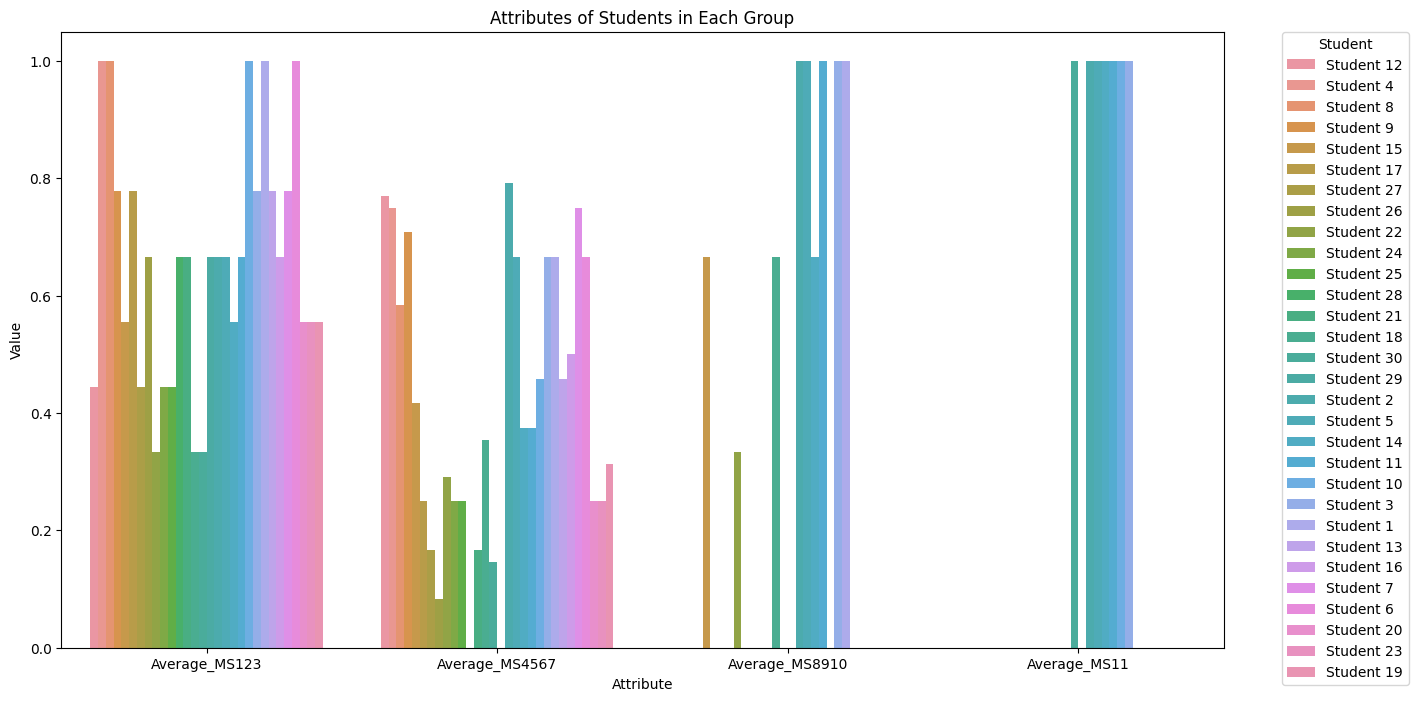

<ipython-input-28-7985a9221630>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  long_format_data = long_format_data.append(
<ipython-input-28-7985a9221630>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

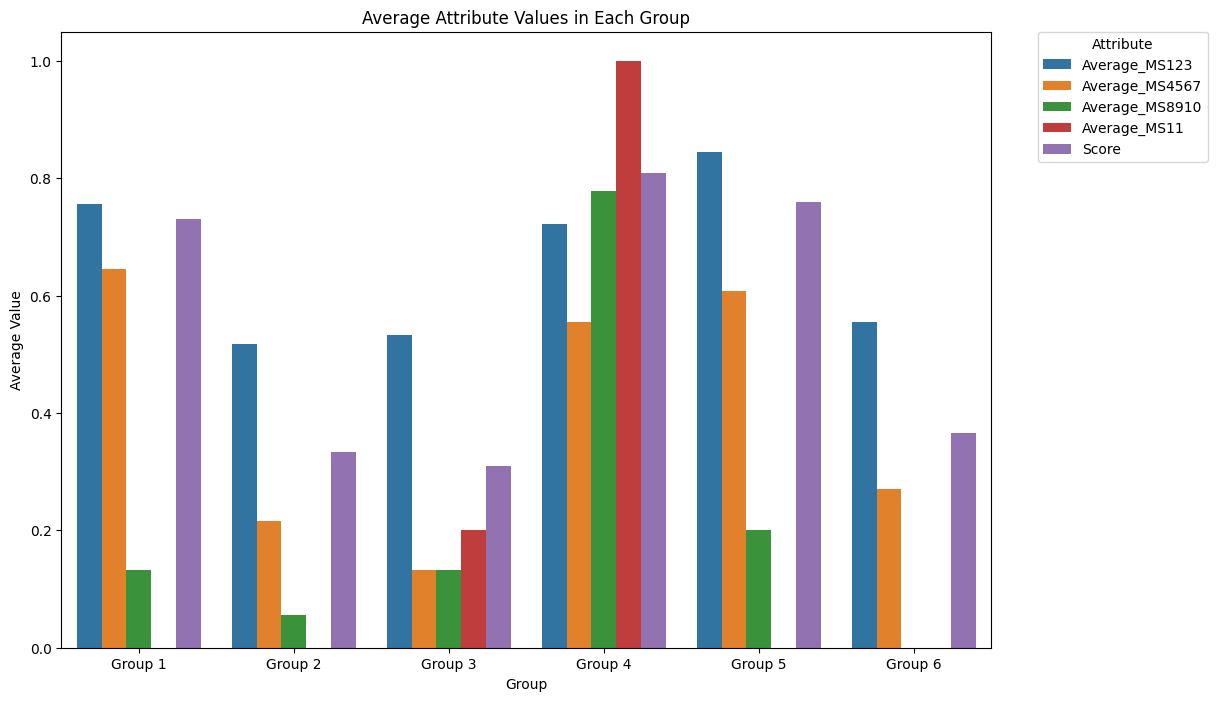

In [ ]:
attributes_score = ['Average_MS123', 'Average_MS4567', 'Average_MS8910', 'Average_MS11', 'Score']
attributes = ['Average_MS123', 'Average_MS4567', 'Average_MS8910', 'Average_MS11']
plot_student_attribute_distribution(eligible_students, attributes)
plot_best_fitness_per_generation(best_fitness_history)
plot_group_score_distribution(best_overall_group_formation)
plot_group_score_boxplot(best_overall_group_formation)
plot_student_individual_attributes(best_overall_group_formation, eligible_students, attributes)
plot_student_average_attributes(best_overall_group_formation, eligible_students, attributes_score)

